## Testing the trained model using a different dataset

The previously trained Densenet-121 model was tested using a "7 point" dataset from the "7-POINT CRITERIA EVALUATION" database.
This dataset includes over 2000 clinical (regular) and dermoscopic (microsocpic) images. The model was separately tested on both clinical and dermosopic images. As the model was originally trained on only microscopic images it did not perform very well on the clinical images. 

This dataset also did not exactly match the 7 skin lesion labels that the Densenet model was trained to detect. This dataset was missing data for the 'akiec' (Actinic keratoses) label so any results pointing to akiec should be ignored.

Some of the steps performed here are taken from the code for original model.

If you'd like to run this file download the 7 point dataset from here: https://derm.cs.sfu.ca (I've made some changes to the original metadata file so I've included this modified verison in this github repository, so if you're running this test juypter notebook please use the modified meta file that can be found in "Others" folder.) 

Scroll down to the bottom of the file to see the confusion matrix results for both dermoscopic and clinical images.

### Imports

In [1]:
%matplotlib inline

# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# show directory of images
print(os.listdir("./data/point/images"))

# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

['A1l', 'A2l', 'A3l', 'Adl', 'Ael', 'FAL', 'FBL', 'FCL', 'FDL', 'FEL', 'FFL', 'Fgl', 'Fhl', 'Fil', 'Fll', 'Fml', 'Gal', 'Gbl', 'Gcl', 'Gdl', 'Ggl', 'Gzl', 'NAL', 'NBL', 'NCL', 'NDL', 'NEL', 'New', 'NFL', 'NGL', 'NHL', 'NIL', 'NLL', 'NML']


### Initializing the labels

In [2]:
data_dir_main = "./data/point/images/"
all_image_path = glob(os.path.join(data_dir_main, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

lesion_type_dict = {    
    "akiec": "akiec",
    'basal cell carcinoma': 'Basal cell carcinoma',
    'seborrheic keratosis': 'Benign keratosis-like lesions ',
    'dermatofibroma': 'Dermatofibroma',
    'reed or spitz nevus': 'Melanocytic nevi',
    'vascular lesion': 'Vascular lesions',
    'melanoma': 'Melanoma'
}

"""
akiec | Actinic keratoses:               0
bcc:  | Basal cell carcinoma             1
blk:  | Benign keratosis-like lesions    2
df    | Dermatofibroma:                  3
nv    | Melanocytic nevi:                4
vasc  | Vascular lesions:                5
mel:  | dermatofibroma                   6
"""

indexMap = {
    'basal cell carcinoma': 1,   # bcc:  | Basal cell carcinoma             1
    'seborrheic keratosis': 2,   # blk:  | Benign keratosis-like lesions    2
    'dermatofibroma': 3,         # df    | Dermatofibroma:                  3
    'vascular lesion': 5,        # vasc  | Vascular lesions:                5
    'reed or spitz nevus': 4,    # nv    | Melanocytic nevi:                4
    'melanoma': 6,               # mel:  | melanoma                         6
}

### Computing mean and standard deviation

In [3]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|██████████| 2013/2013 [00:14<00:00, 137.72it/s]


(224, 224, 3, 2013)
normMean = [0.7260525, 0.6226033, 0.5679677]
normStd = [0.25936174, 0.26400355, 0.26698273]


### Creating a new dataframe with modified csv file labels 

In [5]:
# reading in the csv
data_dir = "./data/point/meta/"
df_original = pd.read_csv(os.path.join(data_dir, 'meta.csv'))

# dermoscopic
df_original['path'] = df_original['derm'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['diagnosis'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = df_original['diagnosis'].map(indexMap.get)
df_original

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,...,location,sex,management,clinic,derm,case_id,notes,path,cell_type,cell_type_idx
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,...,abdomen,female,excision,NEL025,Nel026,NaN,NaN,./data/point/images\NEL\Nel026.jpg,Basal cell carcinoma,1.0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,...,head neck,female,excision,NEL027,Nel028,NaN,NaN,./data/point/images\NEL\Nel028.jpg,Basal cell carcinoma,1.0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,...,head neck,female,excision,Nel032,Nel033,NaN,NaN,./data/point/images\NEL\Nel033.jpg,Basal cell carcinoma,1.0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,...,lower limbs,male,excision,NEL034,Nel035,NaN,NaN,./data/point/images\NEL\Nel035.jpg,Basal cell carcinoma,1.0
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,...,upper limbs,female,excision,NEL036,Nel037,NaN,NaN,./data/point/images\NEL\Nel037.jpg,Basal cell carcinoma,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,1007,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,...,head neck,male,no further examination,Fhl057,Fhl058,NaN,NaN,./data/point/images\Fhl\Fhl058.jpg,Vascular lesions,5.0
1007,1008,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,...,abdomen,female,excision,Fhl059,Fhl060,NaN,NaN,./data/point/images\Fhl\Fhl060.jpg,Vascular lesions,5.0
1008,1009,vascular lesion,0,absent,absent,absent,absent,absent,absent,absent,...,head neck,male,clinical follow up,Fil081,Fil082,NaN,NaN,./data/point/images\Fil\Fil082.jpg,Vascular lesions,5.0
1009,1010,vascular lesion,0,absent,absent,diffuse regular,absent,absent,absent,absent,...,upper limbs,male,no further examination,newl015,newl016,NaN,NaN,./data/point/images\New\newl016.jpg,Vascular lesions,5.0


### Dropping missing values and reseting the index of the dataframe

In [6]:
df_undup = df_original.dropna(subset=['cell_type_idx'])
df_undup = df_undup.reset_index(drop=True)
print(df_undup.shape)

"""
    Display Data Frame
    Note: this will display the whole dataframe most likely crashing jupyter notebook 
    Use at your own risk
"""
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_undup)

(237, 22)


'\n    Display Data Frame\n    Note: this will display the whole dataframe most likely crashing jupyter notebook \n    Use at your own risk\n'

### Creating the df_val dataframe that will be used for the matrix and resetting its index

In [7]:
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.97, random_state=101, stratify=y)
df_val = df_val.reset_index(drop=True)
#print(df_val.shape)

(230, 22)


### Defining a pytorch dataloader

In [8]:
class POINT7(Dataset):
    def __init__(self, df_original, transform=None):
        self.df_original = df_original
        self.transform = transform

    def __len__(self):
        return len(self.df_original)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df_original['path'][index])
        y = torch.tensor(int(self.df_original['cell_type_idx'][index]))
        imageName = self.df_original['path'][index]

        if self.transform:
            X = self.transform(X)

        return X, y, imageName

In [9]:
input_size = 224

val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

validation_set = POINT7(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=0)

### Plotting the confusion matrix

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Loading in the model

In [11]:
model = torch.load("./trainedModel.pth")

## Plotting the confusion Matrix for dermoscopic (microsopic) images 

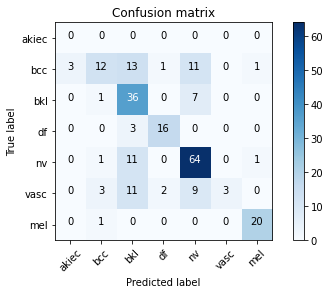

In [12]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels, imageName = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        y_prections = np.squeeze(prediction.cpu().numpy().T)
        # print(y_prections) # this displays the predicted label of the current set
        """ # this will print images that match their label, 6 is melanoma for example
        indexY = 0
        for pred in y_prections:
            if pred == 6:
                print(imageName[indexY])
            indexY += 1
        print("\n")
        """

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

## Plotting the confusion matrix for clinical (regular) images 

In [13]:
df_original['path'] = df_original['clinic'].map(imageid_path_dict.get)
df_undup = df_original.dropna(subset=['cell_type_idx'])
df_undup = df_undup.reset_index(drop=True)
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.97, random_state=101, stratify=y)
df_val = df_val.reset_index(drop=True)
validation_set = POINT7(df_val, transform=val_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=0)

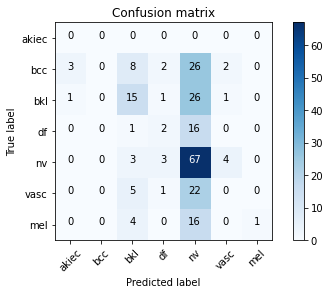

In [15]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels, imageName = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        y_prections = np.squeeze(prediction.cpu().numpy().T)
        # print(y_prections) # this displays the predicted label of the current set
        
        """ # this will print images that match their label (i.e. have been predicted correctly, 6 is melanoma for example
        indexY = 0
        for pred in y_prections:
            if pred == 6:
                print(imageName[indexY])
            indexY += 1
        print("\n")
        """

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)